# Summary and Plot the result

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import pandas as pd
import numpy as np
import os

from utils import *

plt.style.use(['science', 'ieee'])

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

## Dependent Noise results

In [2]:
def plot_metric_props(node_num, seeds=None, flow_types=['IAF', 'DAGGNN'], dep_props=[10,30,50,80], mixed=True, thr=0.3, save=True):
    """
    Plot the metric for different dependence proportions and flow types.
    Args:
        metric_name (str): Name of the metric. ('FDR', 'TPR', 'FPR', 'SHD', 'Predicted Edges')
        node_num (int): Number of nodes.
    """
    colors = ['tab:blue', 'tab:orange', 'tab:green']

    res_fdr = np.zeros((len(dep_props), len(flow_types)))
    res_tpr = np.zeros((len(dep_props), len(flow_types)))
    res_fpr = np.zeros((len(dep_props), len(flow_types)))
    res_shd = np.zeros((len(dep_props), len(flow_types)))
    res_nnz = np.zeros((len(dep_props), len(flow_types)))
    true_nnzs = np.zeros((len(dep_props), len(flow_types)))

    folders = [f for f in os.listdir('results/dependence') if f[0].isdigit()]
    
    for j, dep_prop in enumerate(dep_props):
        for k, flow_type in enumerate(flow_types):
            fs = [f for f in folders if f'_{flow_type}_node{node_num}_prop{dep_prop}' in f]

            if seeds is not None:
                fs = [f for f in fs if int(f.split('_')[5][4:]) in seeds]

            cnt = 0
            for f in fs:
                if 'predG.txt' in os.listdir(f'results/dependence/{f}'):
                    pred_G = np.loadtxt(f'results/dependence/{f}/predG.txt', delimiter=' ').reshape(node_num, node_num)

                    if flow_type == 'IAF' and 'best_ELBO_G.txt' in os.listdir(f'results/dependence/{f}'):
                        pred_G = np.loadtxt(f'results/dependence/{f}/best_ELBO_G.txt', delimiter=' ').reshape(node_num, node_num)

                    if np.isnan(pred_G).any():
                        continue
                    
                    if mixed or ('trueG_DAG.txt' not in os.listdir(f'results/dependence/{f}')):
                        true_G = np.loadtxt(f'results/dependence/{f}/trueG.txt', delimiter=' ').reshape(node_num, node_num)
                    else:
                        true_G = np.loadtxt(f'results/dependence/{f}/trueG_DAG.txt', delimiter=' ').reshape(node_num, node_num)
                    pred_G[np.abs(pred_G) < thr] = 0
                    fdr, tpr, fpr, shd, nnz = count_accuracy(nx.DiGraph(true_G), nx.DiGraph(pred_G))
                    true_nnz = np.count_nonzero(true_G)
                        
                    res_fdr[j, k] += fdr
                    res_tpr[j, k] += tpr
                    res_fpr[j, k] += fpr
                    res_shd[j, k] += shd
                    res_nnz[j, k] += nnz
                    true_nnzs[j, k] += true_nnz
                    cnt += 1

            if cnt == 0:
                continue
            res_fdr[j, k] /= cnt
            res_tpr[j, k] /= cnt
            res_fpr[j, k] /= cnt
            res_shd[j, k] /= cnt
            res_nnz[j, k] /= cnt
            true_nnzs[j, k] /= cnt

    all_res = {'FDR' : res_fdr, 'TPR' : res_tpr, 'FPR' : res_fpr, 'SHD' : res_shd, 'Predicted Edges' : res_nnz}

    for metric_name in all_res.keys():
        res = all_res[metric_name]

        fig, ax = plt.subplots(1, 1, figsize=(6, 4))

        for k, flow_type in enumerate(flow_types):
            ax.plot(dep_props, res[:, k], label=flow_type, marker='o', color=colors[k], linestyle='--')
        
        if metric_name == 'Predicted Edges':
            ax.plot(dep_props, true_nnzs[:, 0], label='True Edges', marker='o', color=colors[2], linestyle='--')

        ax.set_xlabel('Dependence Proportion')
        ax.set_ylabel(metric_name)
        mixed_str = 'Mixed' if mixed else 'DAG'
        ax.set_title(f'{metric_name} for {node_num} Nodes : {mixed_str}')
        ax.legend()
        plt.tight_layout()
        if save:
            plt.savefig(f'Tex/fig/{metric_name}_dependence_{node_num}_{mixed_str}_threshold{thr}.pdf')
        else:
            plt.show()

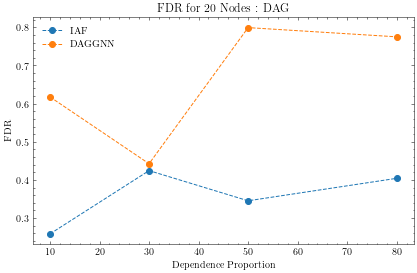

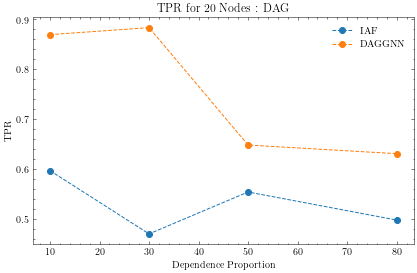

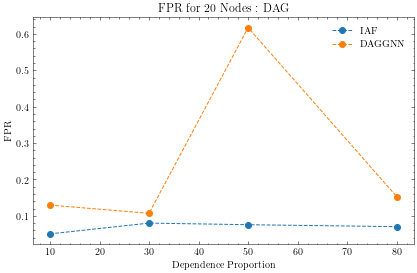

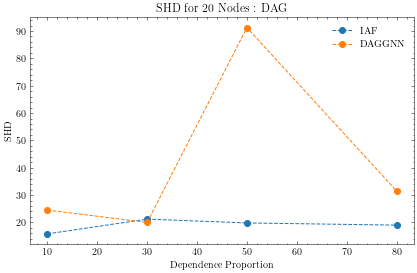

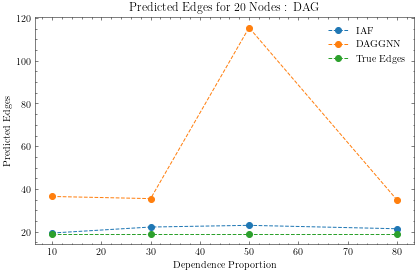

In [3]:
plot_metric_props(node_num = 20, seeds = [11,21,31,41,51], mixed=False)

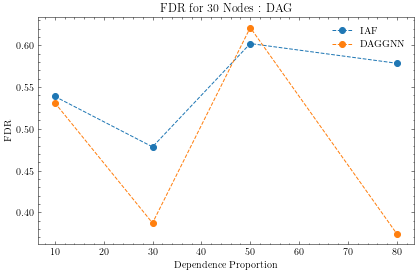

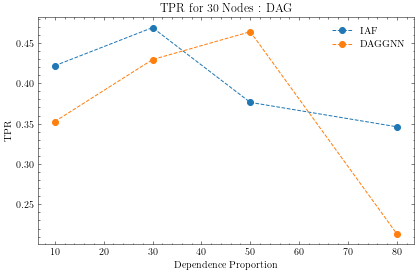

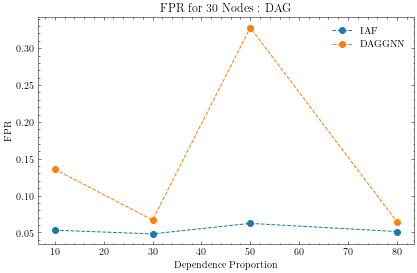

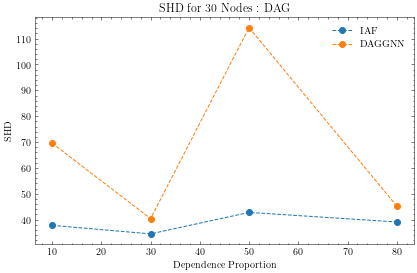

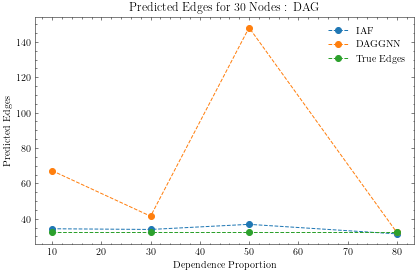

In [27]:
plot_metric_props(node_num=30, dep_props=[10,30,50,80], mixed=False, save=True)

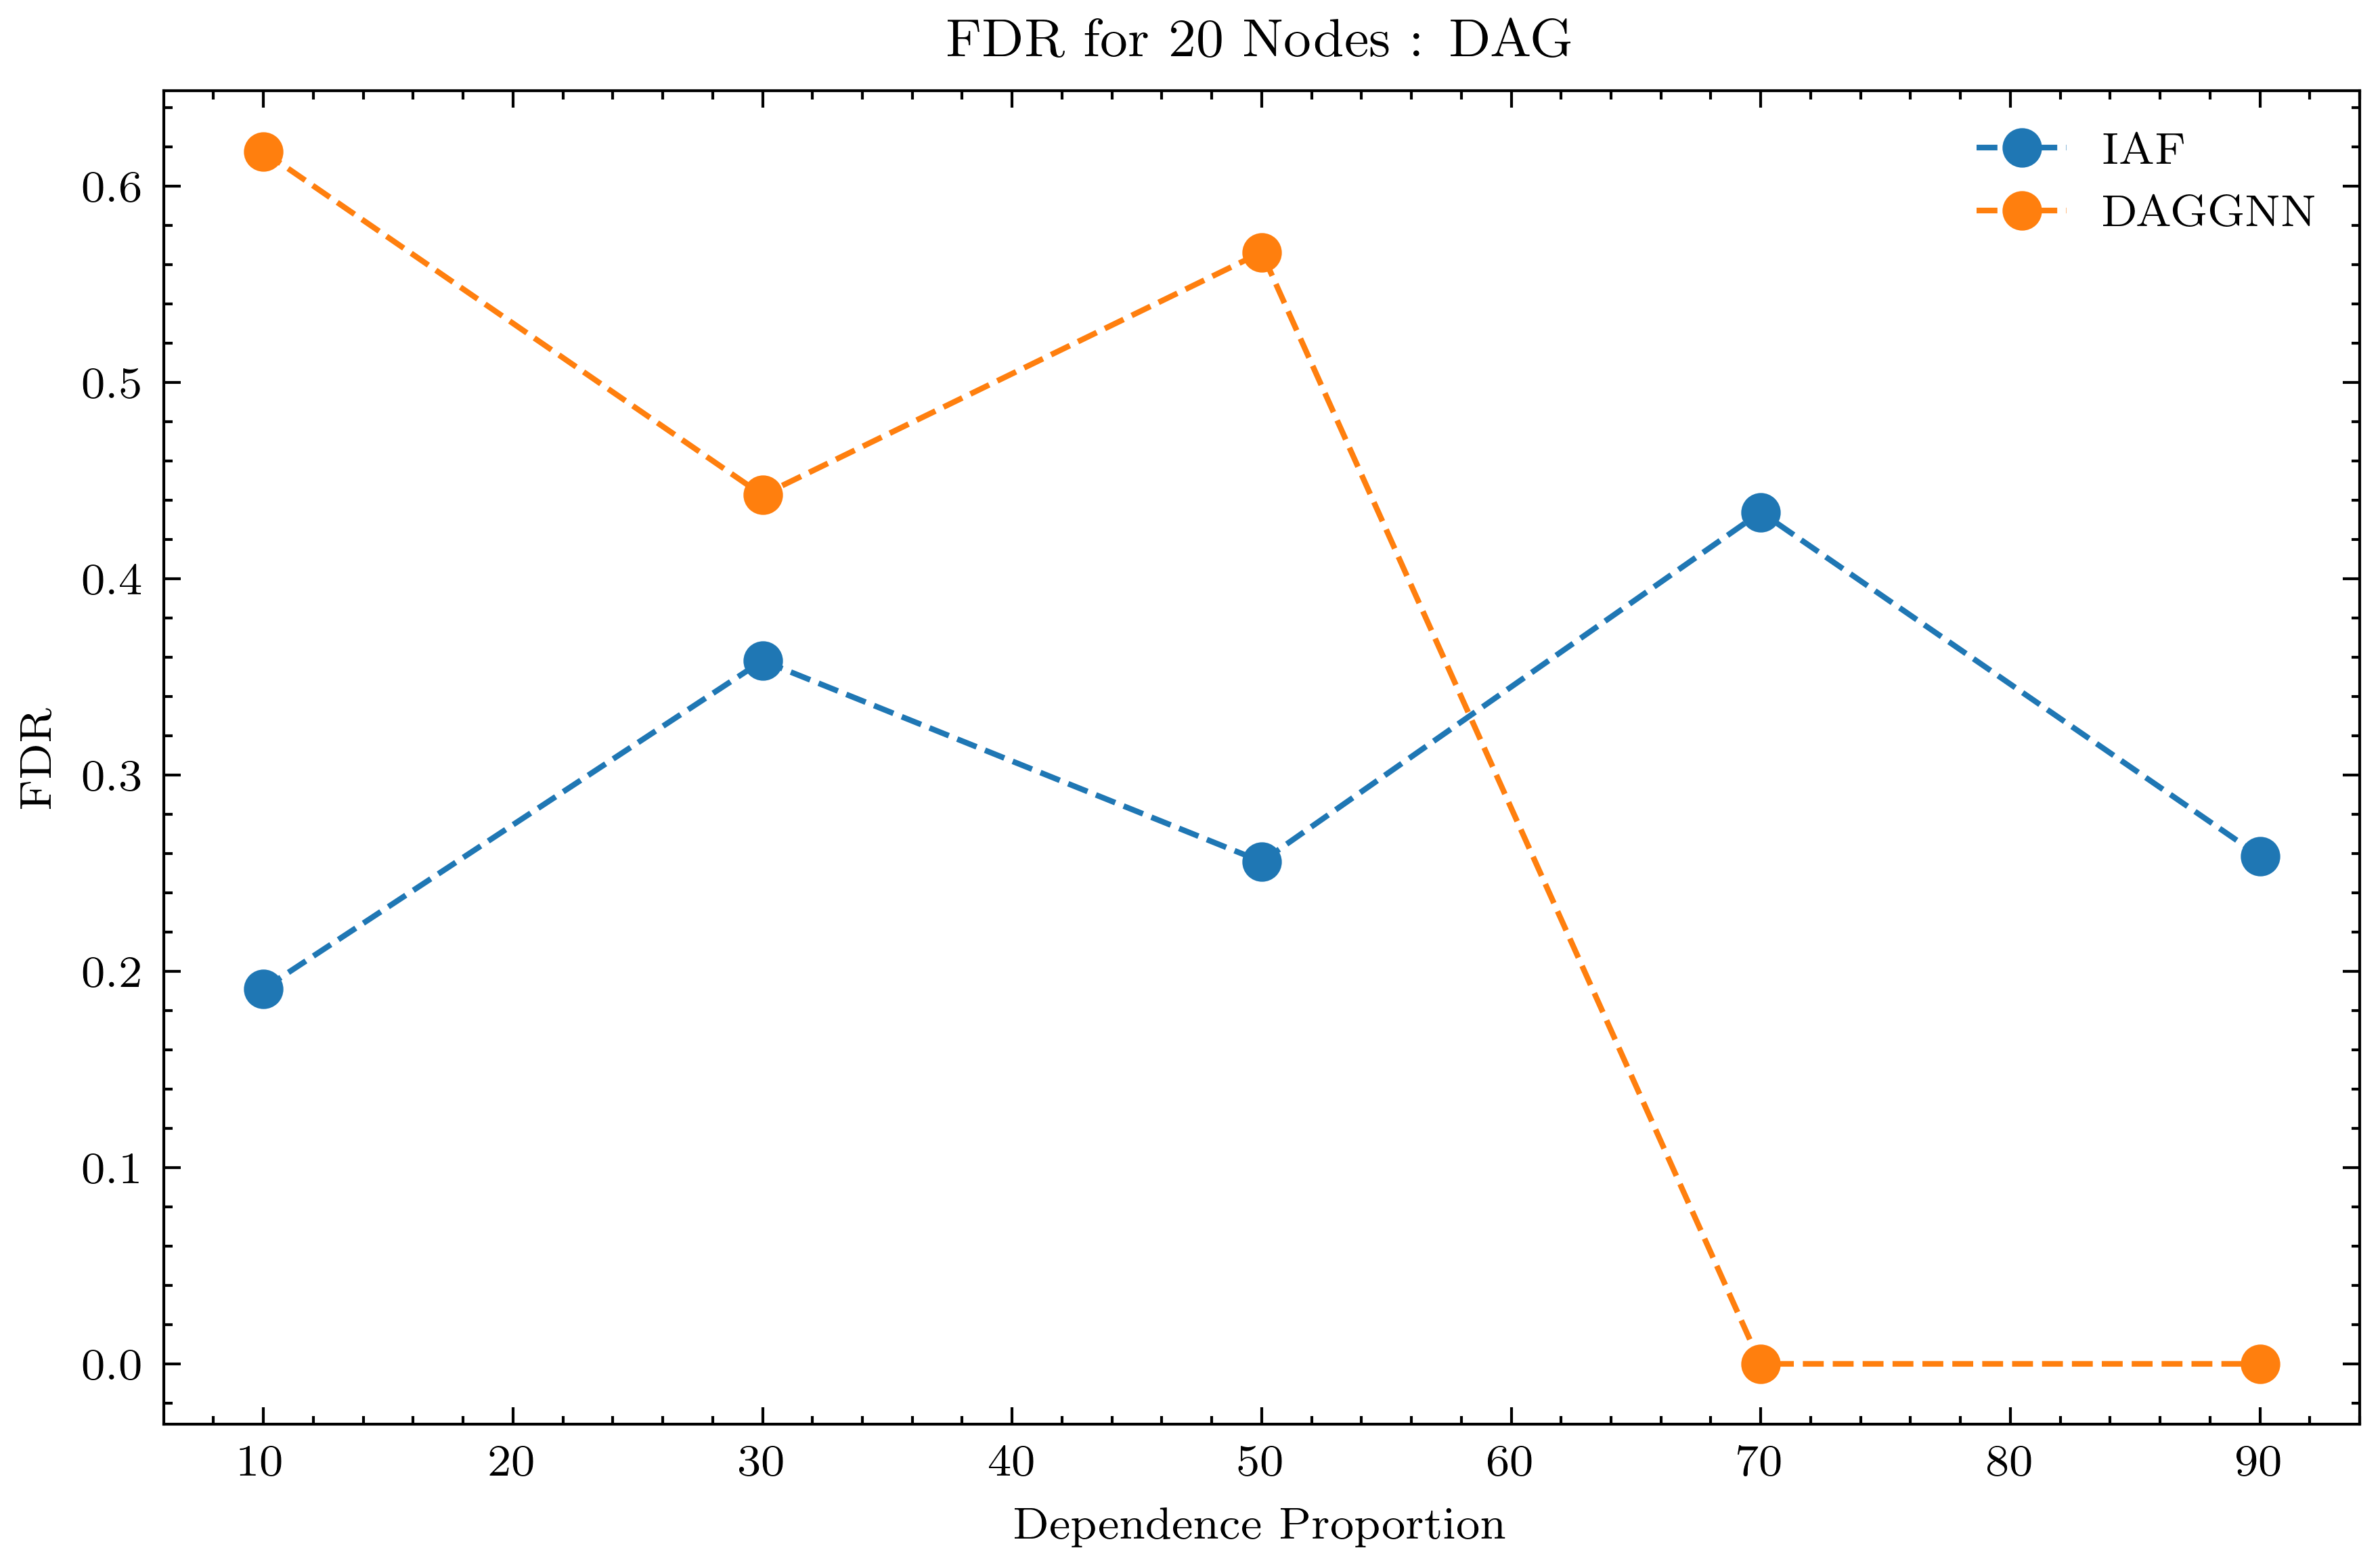

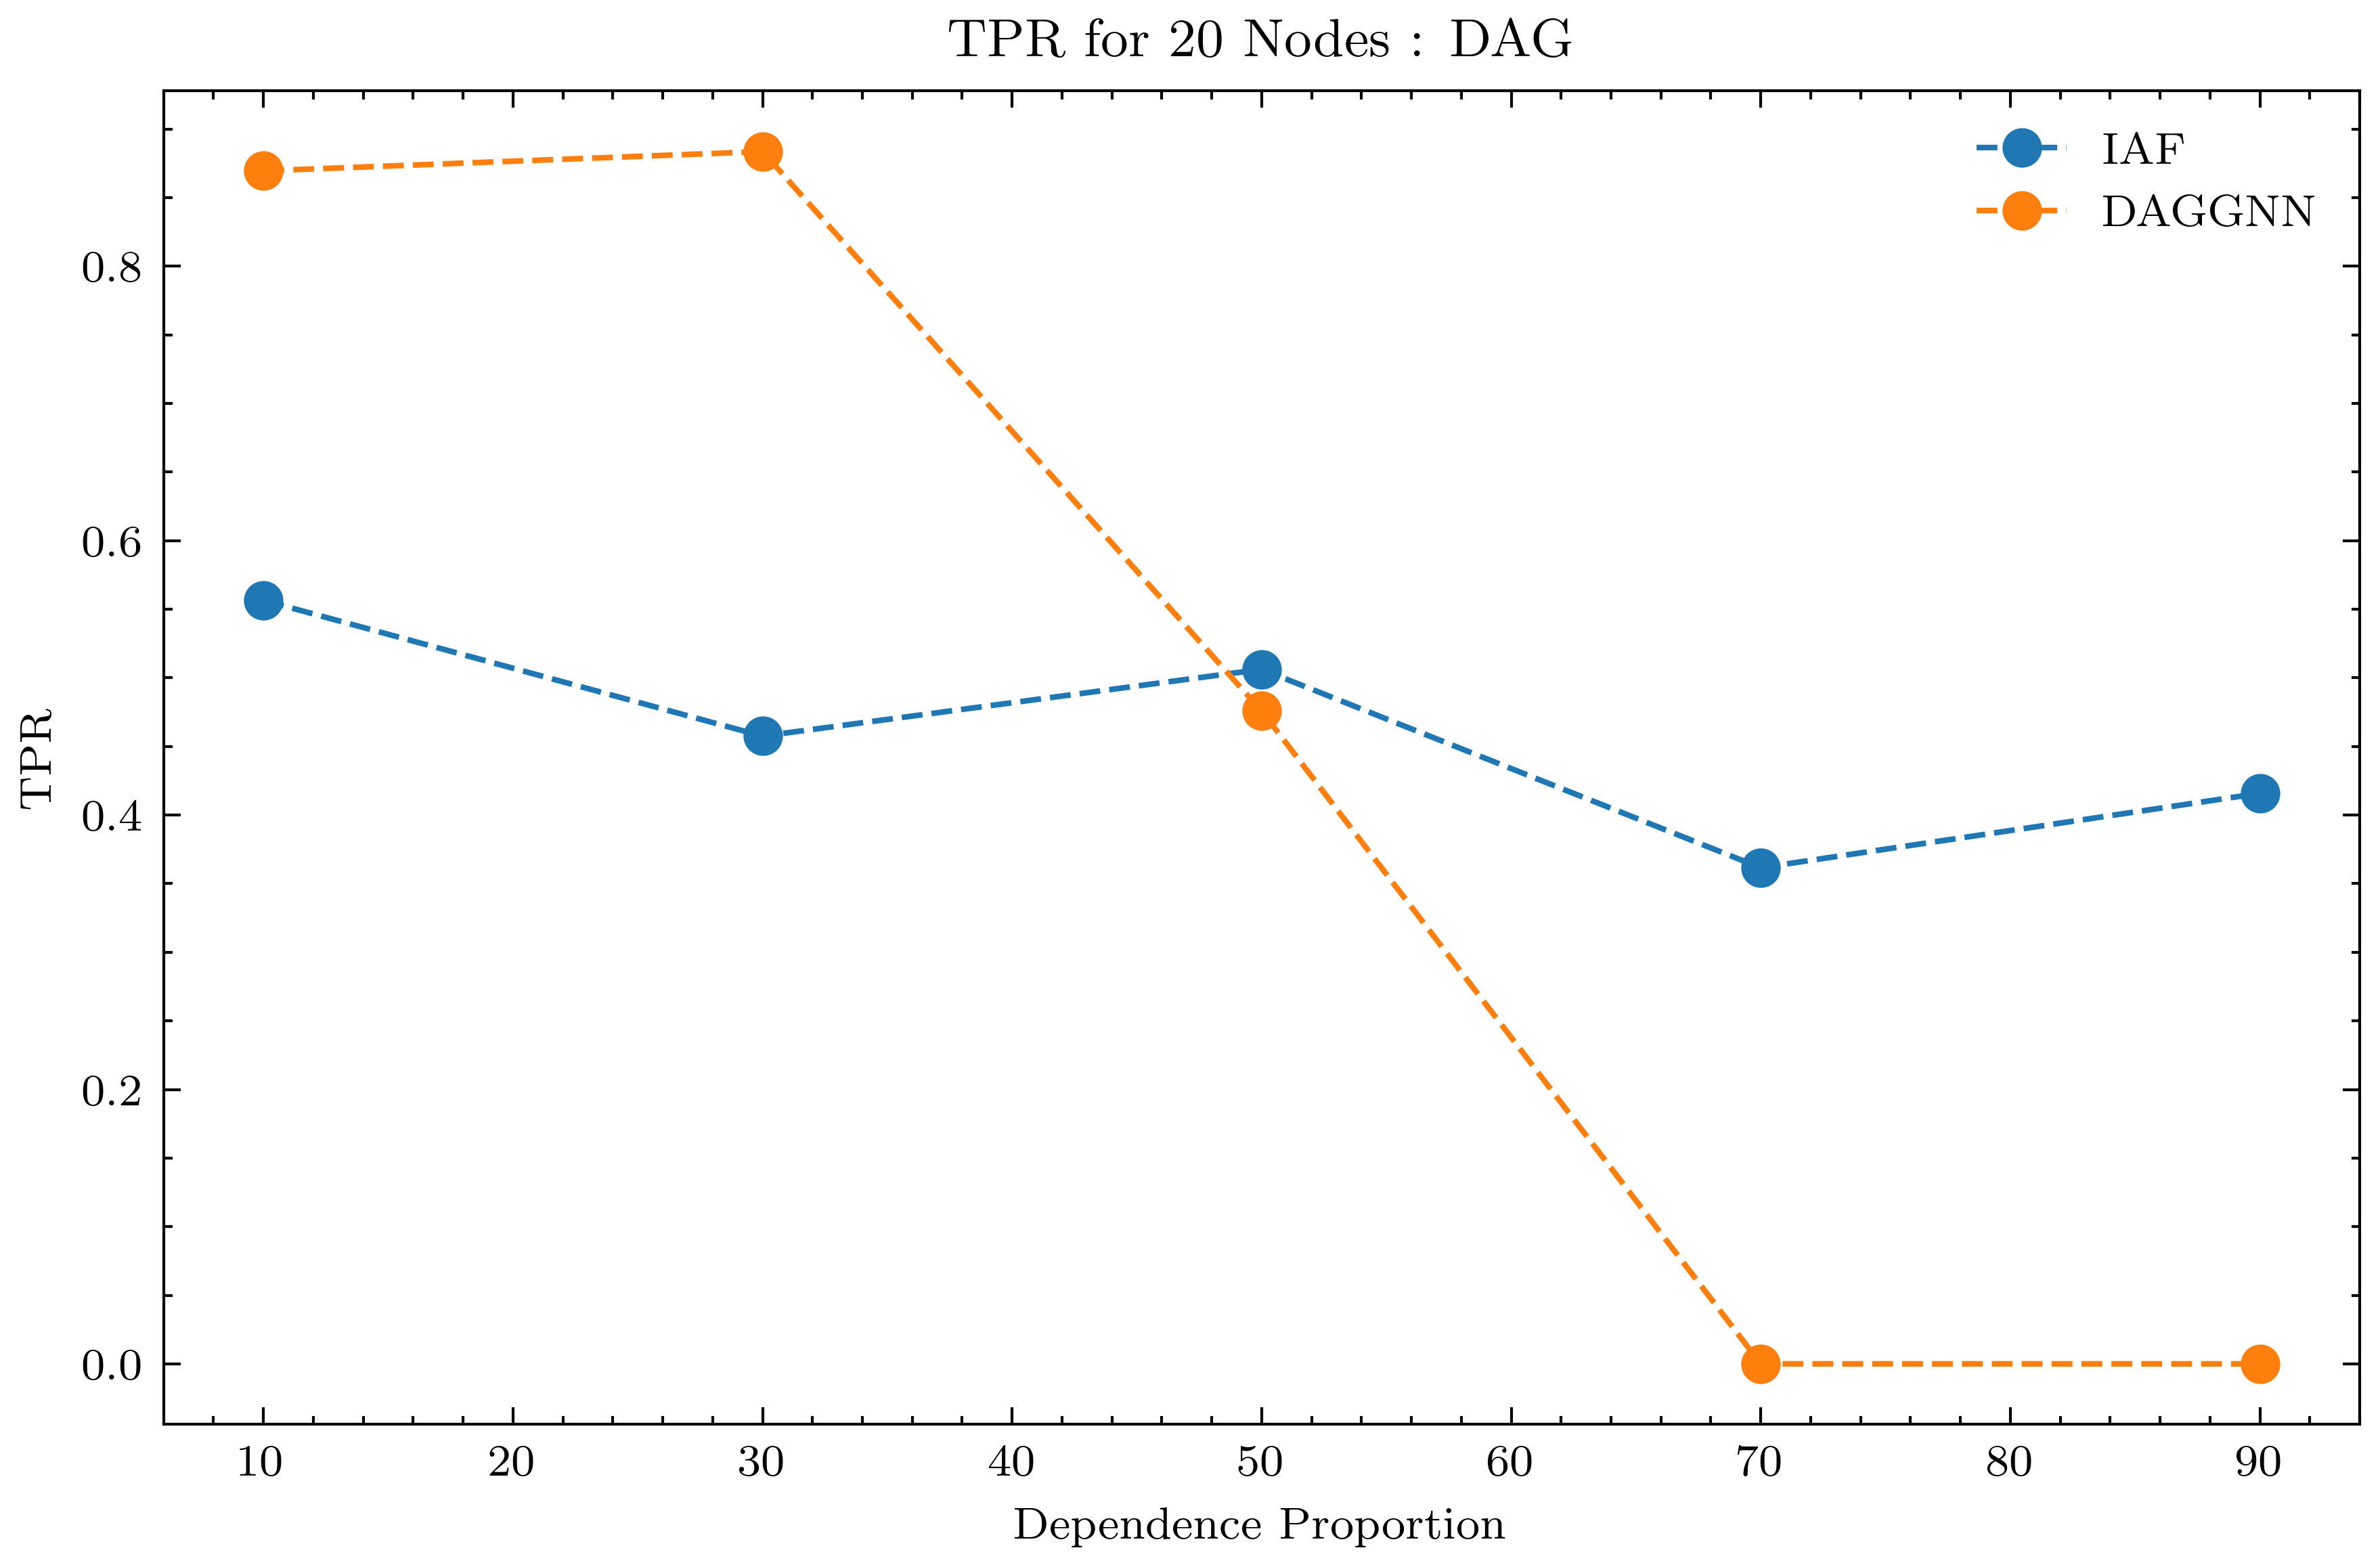

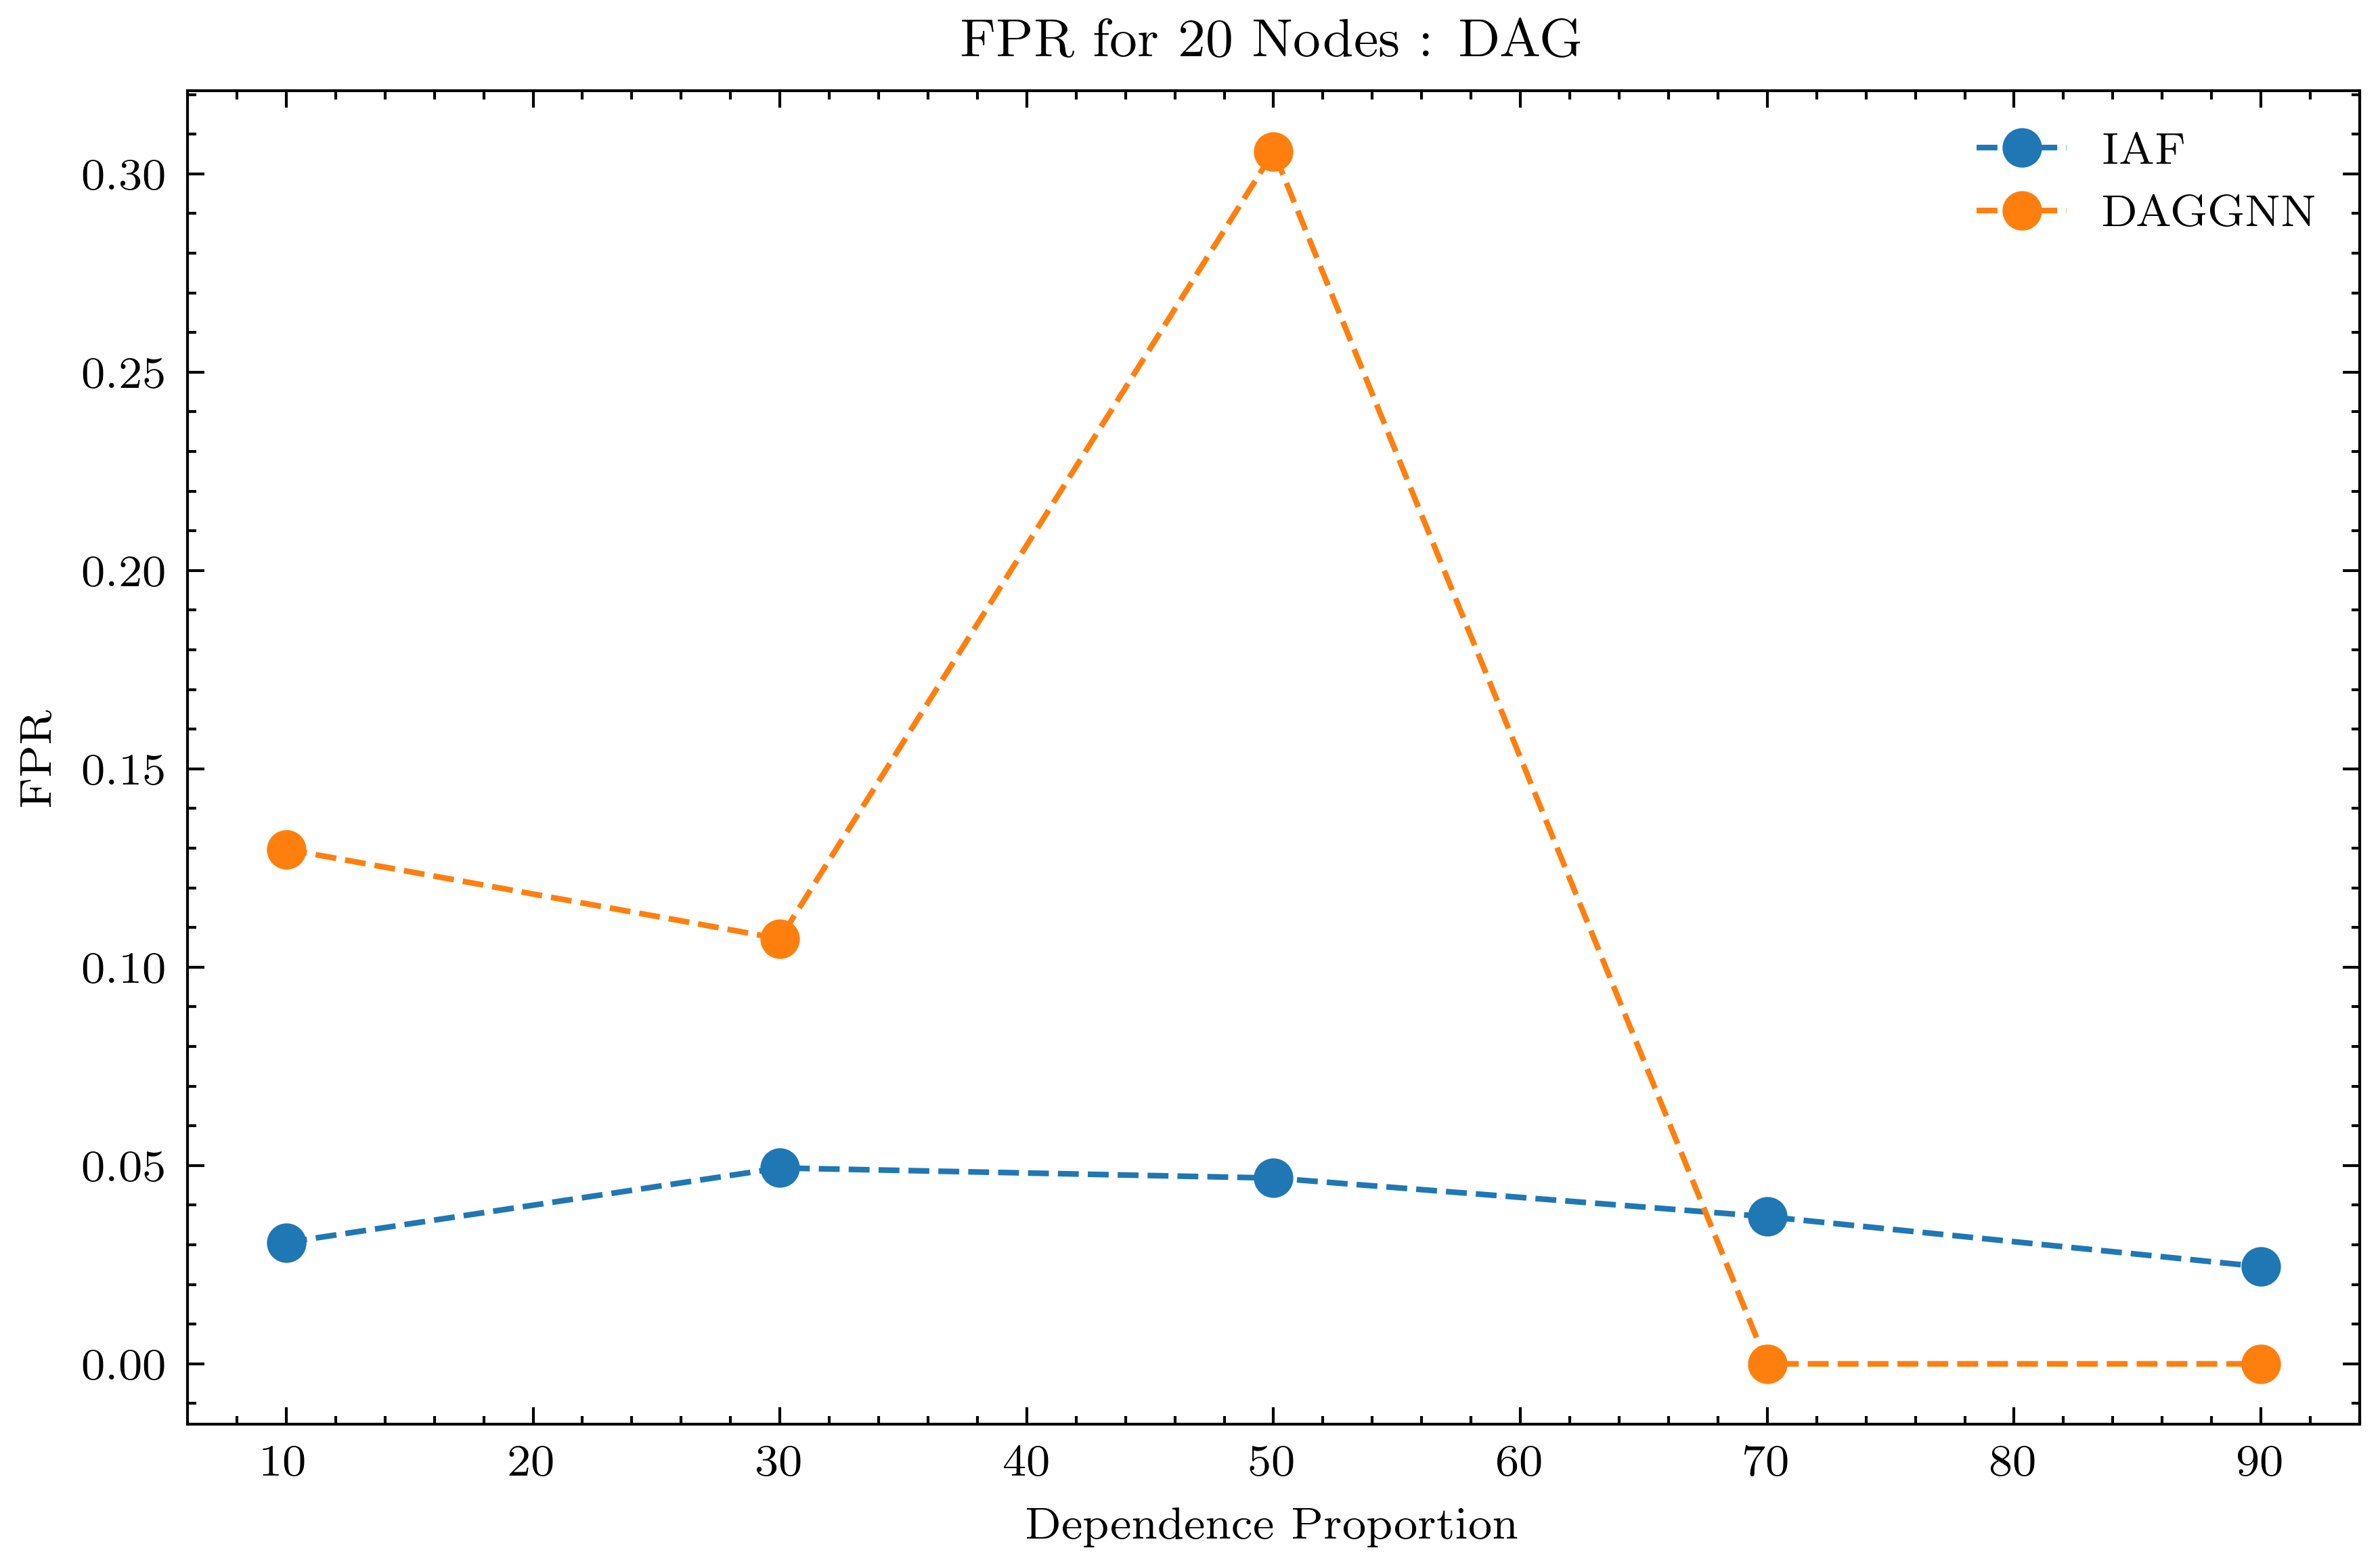

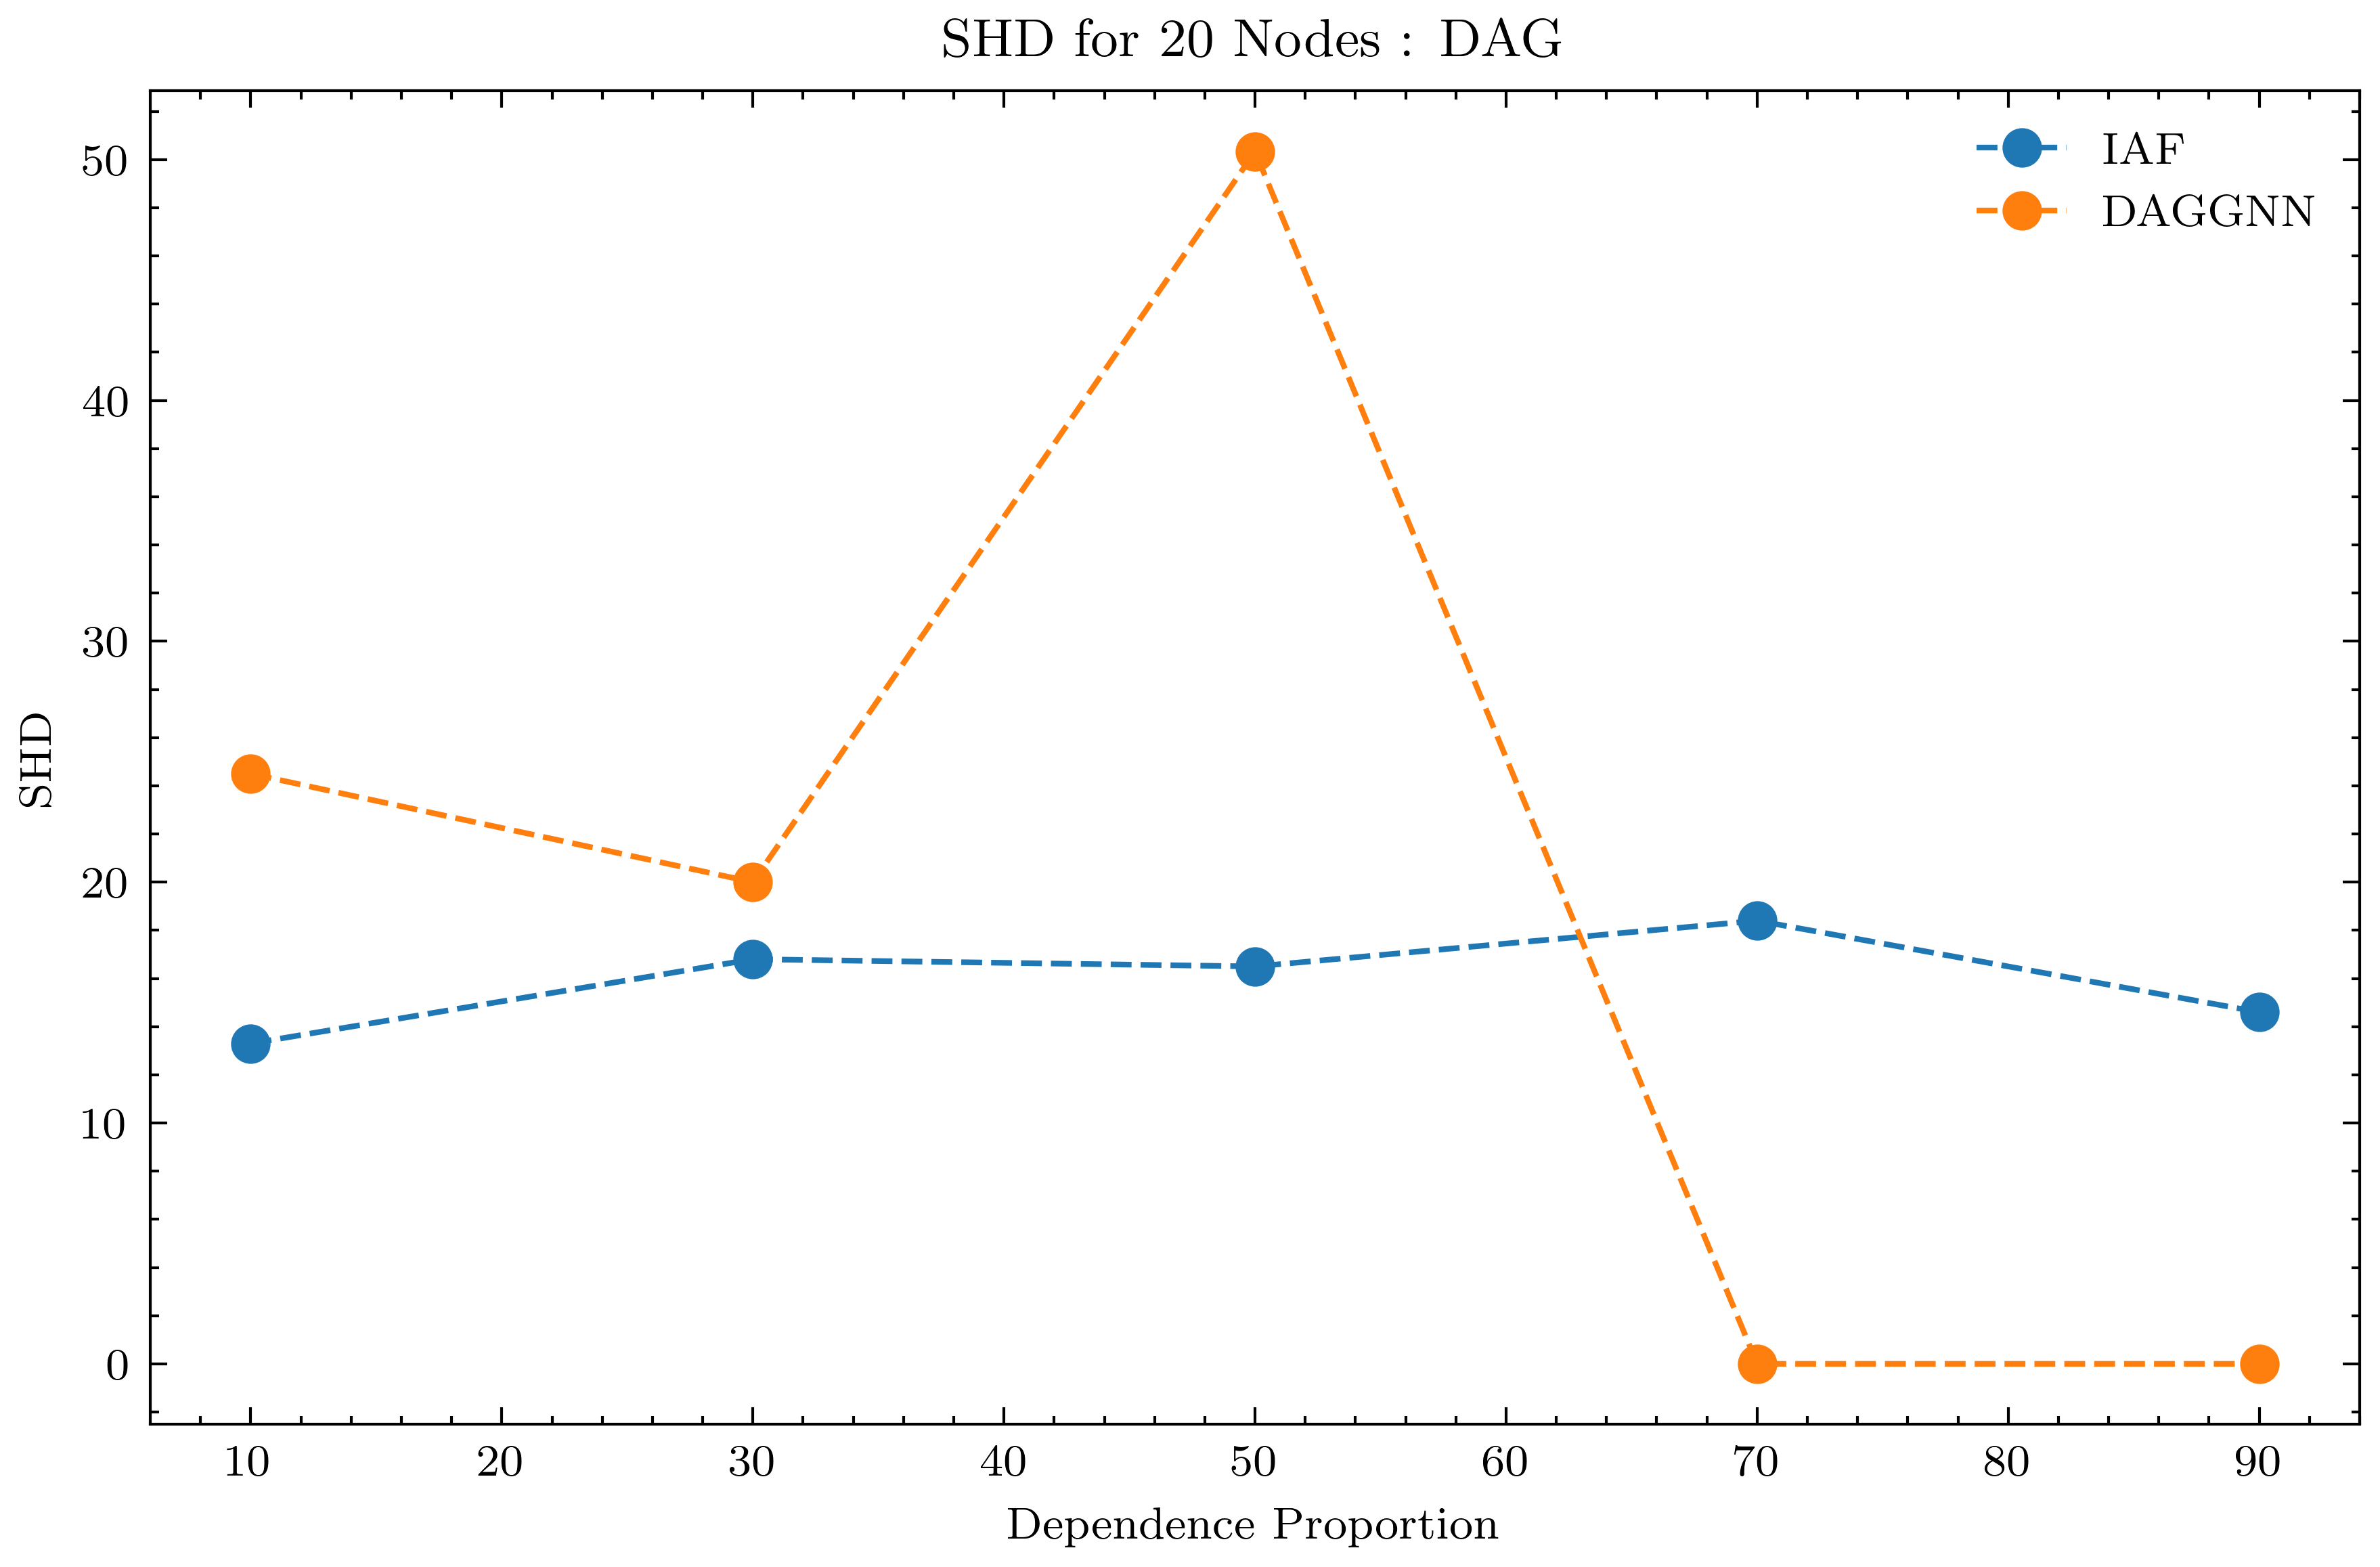

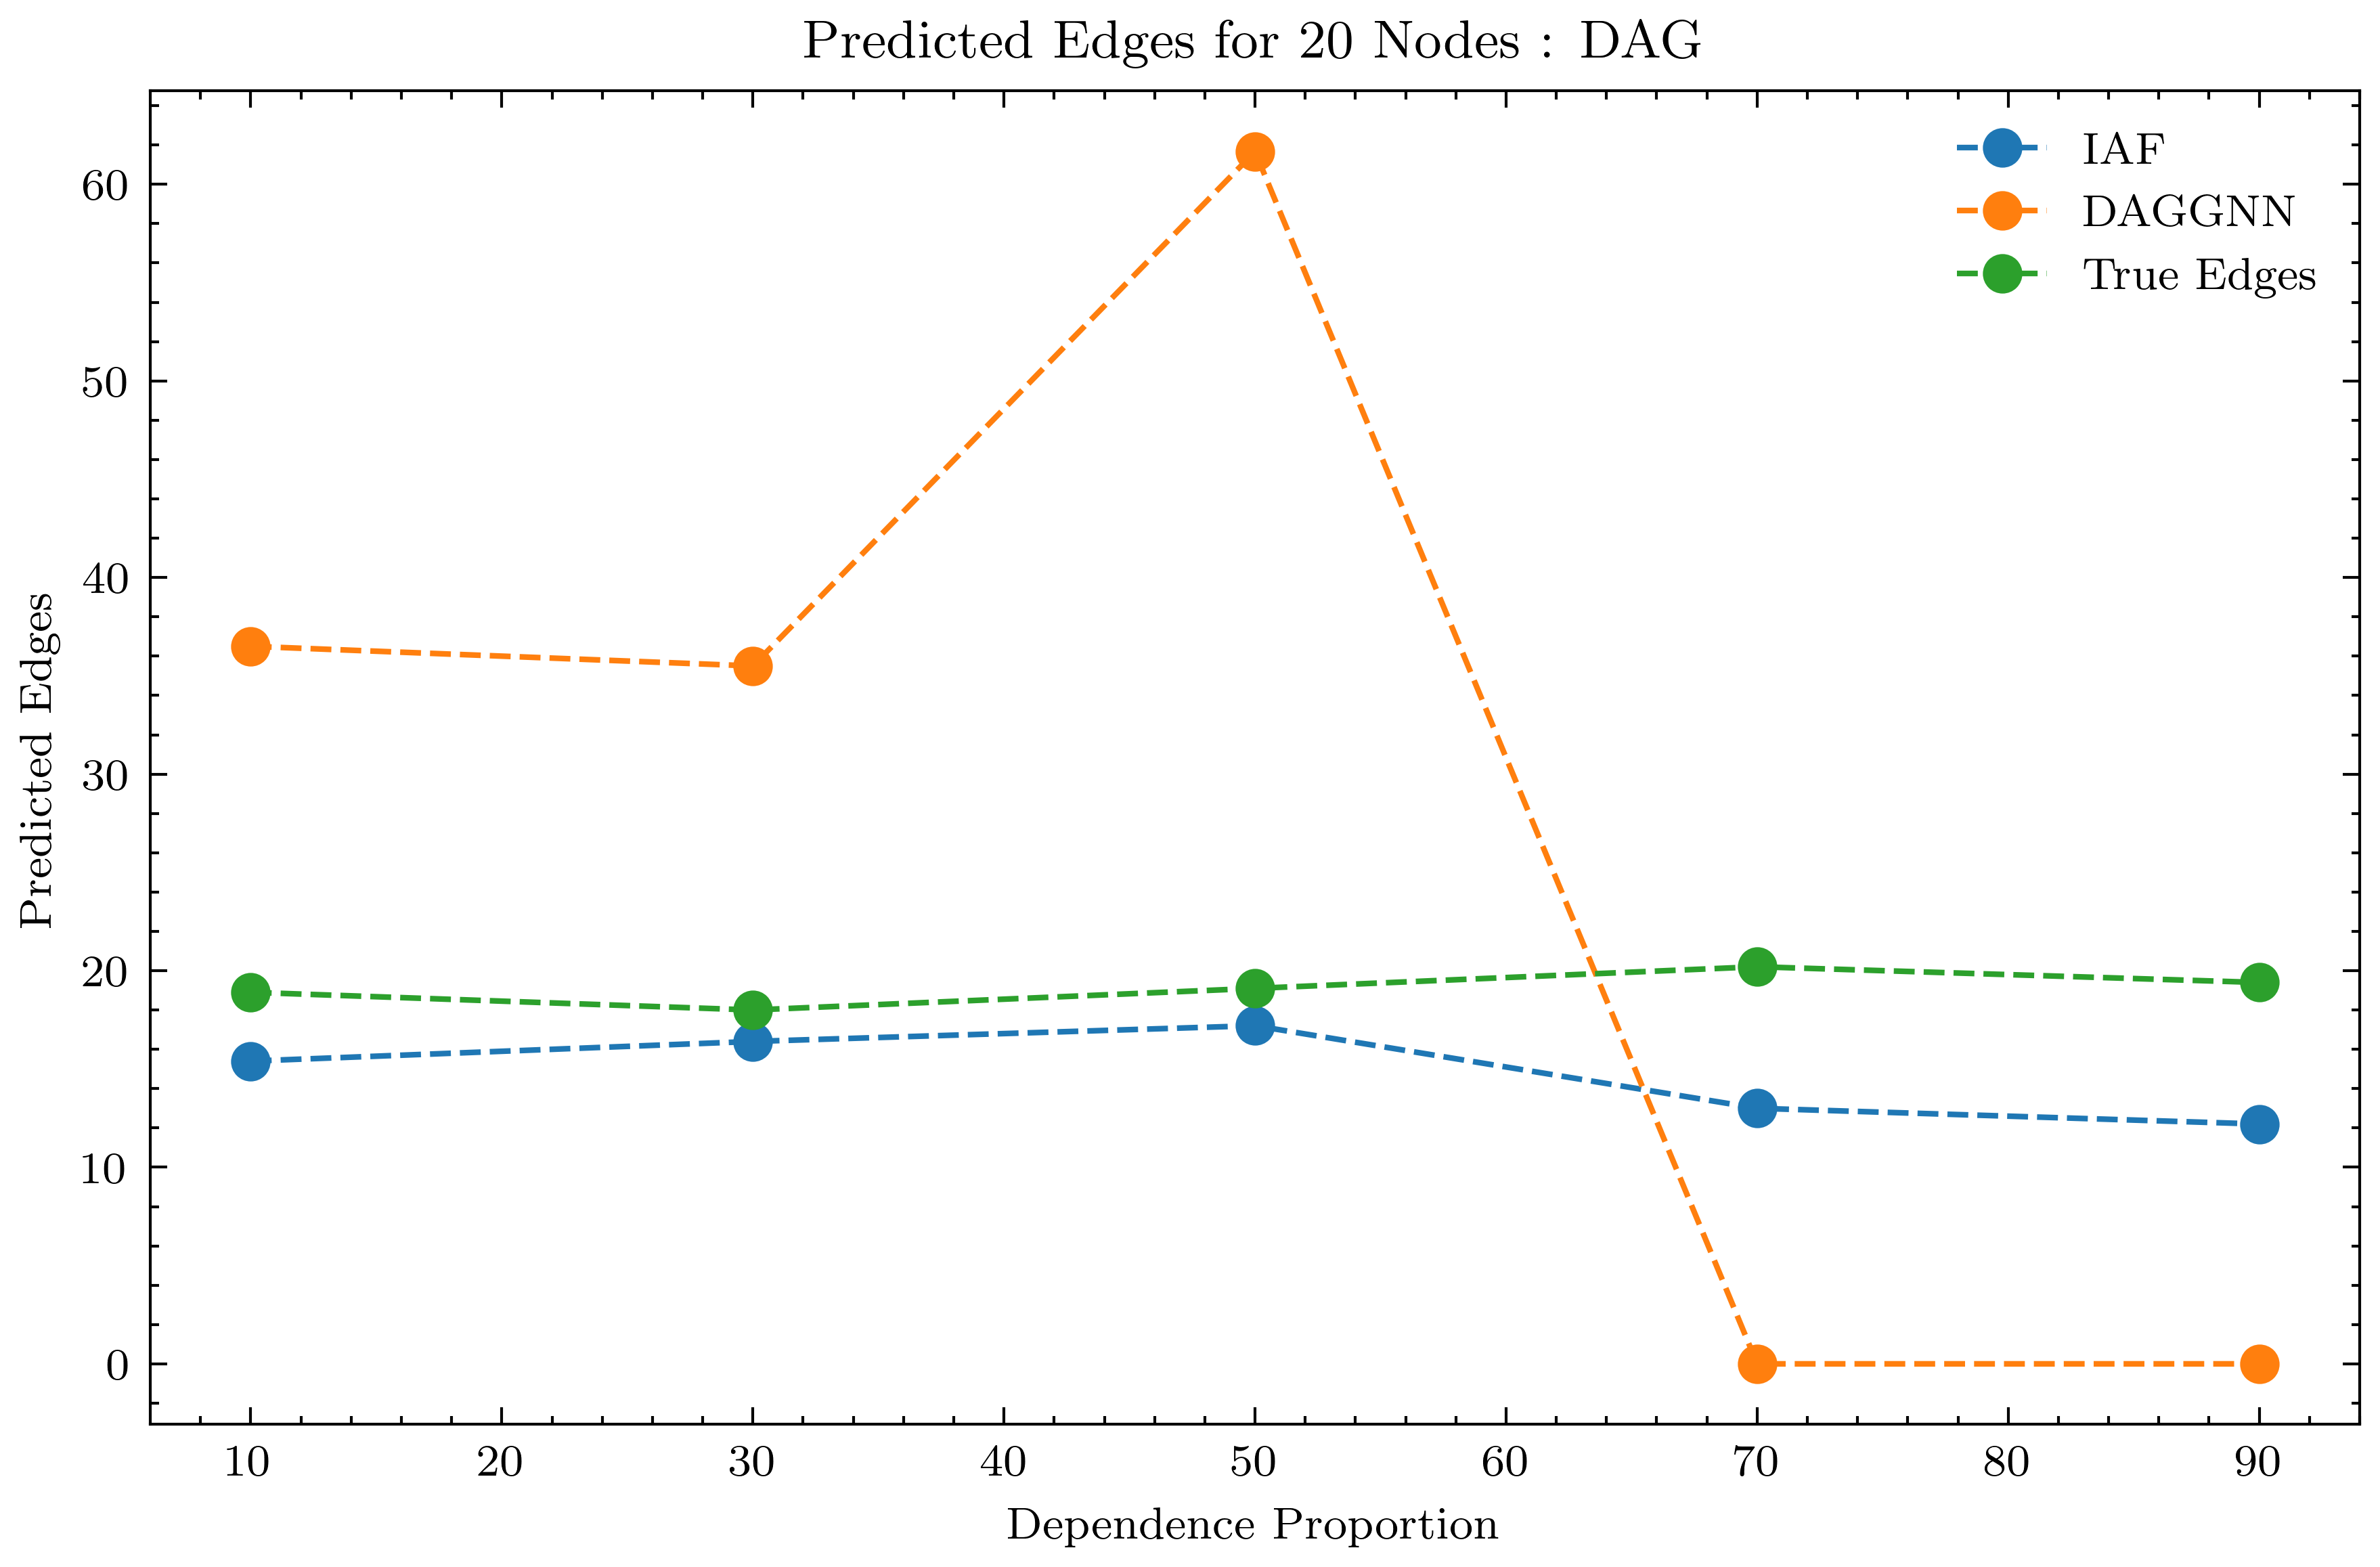

In [6]:
plot_metric_props(node_num=20, dep_props=[10,30,50,70,90], mixed=False, save=False) # 재석님이 돌린것

In [4]:
def plot_metric_nodes(dep_prop, node_nums=[10,20,30,50], seeds=None, flow_types=['IAF','DAGGNN']):
    """
    Plot the metric for different node numbers and flow types, with fixed dependence proportion.
    """

    colors = ['tab:blue', 'tab:orange', 'tab:green']

    res_fdr = np.zeros((len(node_nums), len(flow_types)))
    res_tpr = np.zeros((len(node_nums), len(flow_types)))
    res_fpr = np.zeros((len(node_nums), len(flow_types)))
    res_shd = np.zeros((len(node_nums), len(flow_types)))
    res_nnz = np.zeros((len(node_nums), len(flow_types)))
    true_nnzs = np.zeros((len(node_nums), len(flow_types)))

    folders = [f for f in os.listdir('results/dependence') if f[0].isdigit()]

    for i, node_num in enumerate(node_nums):
        for k, flow_type in enumerate(flow_types):
            fs = [f for f in folders if f'_{flow_type}_node{node_num}_prop{dep_prop}' in f]

            if seeds is not None:
                fs = [f for f in fs if int(f.split('_')[5][4:]) in seeds]

            cnt = 0
            for f in fs:
                if 'predG.txt' in os.listdir(f'results/dependence/{f}'):
                    pred_G = np.loadtxt(f'results/dependence/{f}/predG.txt', delimiter=' ').reshape(node_num, node_num)

                    if flow_type == 'IAF' and 'best_ELBO_G.txt' in os.listdir(f'results/dependence/{f}'):
                        pred_G = np.loadtxt(f'results/dependence/{f}/best_ELBO_G.txt', delimiter=' ').reshape(node_num, node_num)

                    if np.isnan(pred_G).any():
                        continue
                    true_G = np.loadtxt(f'results/dependence/{f}/trueG.txt', delimiter=' ').reshape(node_num, node_num)
                    pred_G[np.abs(pred_G) < 0.3] = 0
                    fdr, tpr, fpr, shd, nnz = count_accuracy(nx.DiGraph(true_G), nx.DiGraph(pred_G))
                    true_nnz = np.count_nonzero(true_G)
                        
                    res_fdr[i, k] += fdr
                    res_tpr[i, k] += tpr
                    res_fpr[i, k] += fpr
                    res_shd[i, k] += shd
                    res_nnz[i, k] += nnz
                    true_nnzs[i, k] += true_nnz
                    cnt += 1

            if cnt == 0:
                continue

            res_fdr[i, k] /= cnt
            res_tpr[i, k] /= cnt
            res_fpr[i, k] /= cnt
            res_shd[i, k] /= cnt
            res_nnz[i, k] /= cnt
            true_nnzs[i, k] /= cnt

    all_res = {'FDR' : res_fdr, 'TPR' : res_tpr, 'FPR' : res_fpr, 'SHD' : res_shd, 'Predicted Edges' : res_nnz}
    
    for metric_name in all_res.keys():

        fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        res = all_res[metric_name]

        for k, flow_type in enumerate(flow_types):
            ax.plot(node_nums, res[:, k], label=flow_type, marker='o', color=colors[k], linestyle='--')
        
        if metric_name == 'Predicted Edges':
            ax.plot(node_nums, true_nnzs[:, 0], label='True Edges', marker='o', color=colors[2], linestyle='--')
        ax.set_xlabel('Node Number')
        ax.set_ylabel(metric_name)

        ax.set_title(f'{metric_name} for Dependence Proportion {dep_prop}%')
        ax.legend()
        plt.tight_layout()
        plt.savefig(f'Tex/fig/{metric_name}_dependence_{dep_prop}.pdf')

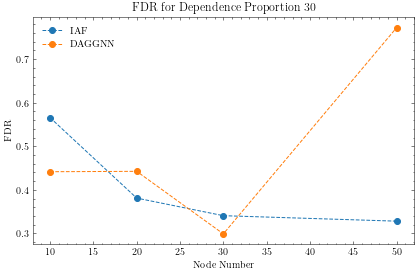

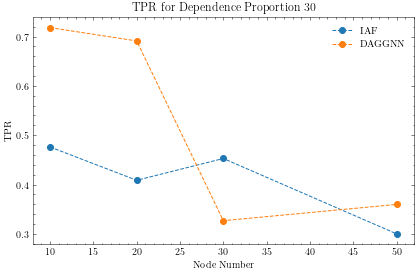

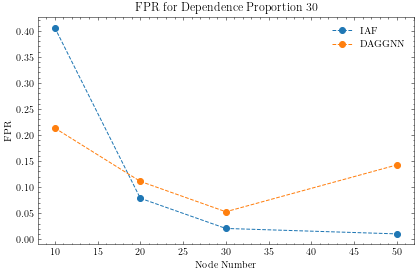

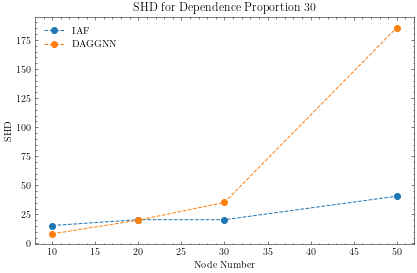

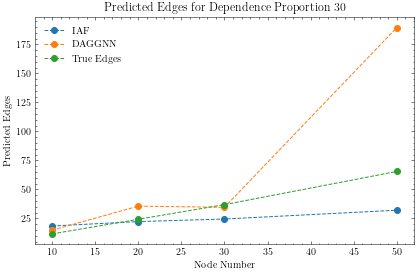

In [5]:
plot_metric_nodes(30, seeds=[11,21,31,41,51], flow_types=['IAF','DAGGNN'])

In [15]:
def plot_comparison(node_num, dep_prop, seed=None, flow_types=['IAF', 'DAGGNN'], mixed=False):

    folders = [f for f in os.listdir('results/dependence') if f[0].isdigit()]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for idx, flow_type in enumerate(flow_types):
        folder = [f for f in folders if f.endswith(f'{flow_types[idx]}_node{node_num}_prop{dep_prop}')]

        if seed:
            folder = [f for f in folders if f.endswith(f'{flow_types[idx]}_node{node_num}_prop{dep_prop}_seed{seed}')]

        folder = folder[0]

        pred_G = np.loadtxt(f'results/dependence/{folder}/predG.txt', delimiter=' ').reshape(node_num, node_num)

        if flow_type == 'IAF' and 'best_ELBO_G.txt' in os.listdir(f'results/dependence/{folder}'):
            pred_G = np.loadtxt(f'results/dependence/{folder}/best_ELBO_G.txt', delimiter=' ').reshape(node_num, node_num)

        if mixed:
            true_G = np.loadtxt(f'results/dependence/{folder}/trueG.txt', delimiter=' ').reshape(node_num, node_num)
        else:
            true_G = np.loadtxt(f'results/dependence/{folder}/trueG_DAG.txt', delimiter=' ').reshape(node_num, node_num)
        
        pred_G[np.abs(pred_G) < 0.3] = 0
        fdr, tpr, fpr, shd, nnz = count_accuracy(nx.DiGraph(true_G), nx.DiGraph(pred_G))

        if idx == 0:
            sns.heatmap(true_G, cmap=newcmp, ax=axes[0], vmin=-2, vmax=2, cbar=False)
            mixed_str = 'Mixed' if mixed else 'DAG'
            axes[0].set_title(f'True Graph({mixed_str})', fontsize=20)
            for _, spine in axes[0].spines.items():
                spine.set_visible(True)
            axes[0].set_xticks([])
            axes[0].set_yticks([])
        sns.heatmap(pred_G, cmap=newcmp, ax=axes.ravel()[idx+1], vmin=-2, vmax=2, cbar_ax = cbar_ax if idx == 0 else None, cbar = (idx == 0))
        axes.ravel()[idx+1].set_title(flow_types[idx] + f' (SHD = {shd})', fontsize=20)
        for _, spine in axes.ravel()[idx+1].spines.items():
            spine.set_visible(True)
        axes.ravel()[idx+1].set_xticks([])
        axes.ravel()[idx+1].set_yticks([])

    fig.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig(f'Tex/fig/comparison_dep_{node_num}_{dep_prop}_seed{seed}.pdf')

/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_24929/3146879506.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


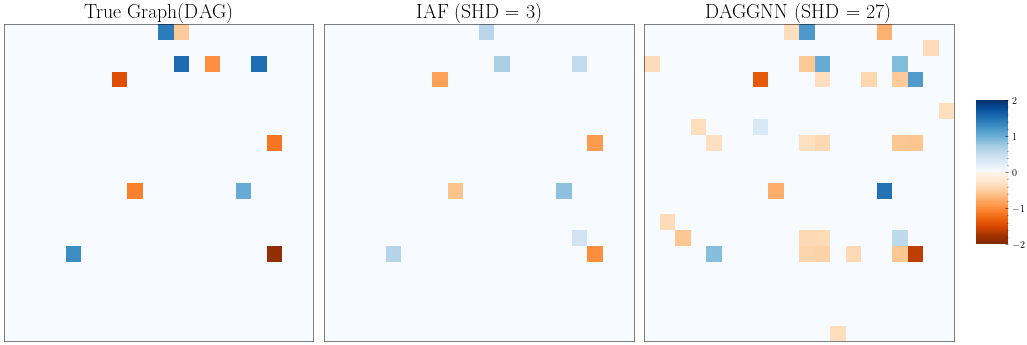

In [16]:
plot_comparison(node_num=20, dep_prop=50, seed=31, mixed=False)

In [8]:
def plot_cov(node_num, prop, seed, flow_type='IAF'):
    folders = [f for f in os.listdir('results/dependence') if f[0].isdigit()]
    folder = [f for f in folders if f'{flow_type}_node{node_num}_prop{prop}_seed{seed}' in f][0]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    true_cov = np.loadtxt(f'results/dependence/{folder}/cov.txt', delimiter=' ').reshape(node_num, node_num)
    pred_cov = np.loadtxt(f'results/dependence/{folder}/cov_pred.txt', delimiter=' ').reshape(node_num, node_num)

    sns.heatmap(true_cov, cmap=newcmp, ax=axes[0], vmin=-2, vmax=2, cbar=True, cbar_ax=cbar_ax)
    axes[0].set_title('True Covariance', fontsize=20)
    for _, spine in axes[0].spines.items():
        spine.set_visible(True)
    axes[0].set_xticks([])  
    axes[0].set_yticks([])
    sns.heatmap(pred_cov, cmap=newcmp, ax=axes[1], vmin=-2, vmax=2, cbar=False)
    axes[1].set_title('Predicted Covariance', fontsize=20)
    for _, spine in axes[1].spines.items():
        spine.set_visible(True)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    fig.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig(f'plots/cov_dep_{node_num}_{prop}.pdf', facecolor='white')

# Independent Noise results

In [5]:
def plot_indep(dist, node_nums=[10,20,30,50], seeds=None, flow_types=['IAF', 'DAGGNN']):
    folders = [f for f in os.listdir(f'results/independence/{dist}') if f[0].isdigit()]

    colors = ['tab:blue', 'tab:orange', 'tab:green']

    res_fdr = np.zeros((len(node_nums), len(flow_types)))
    res_tpr = np.zeros((len(node_nums), len(flow_types)))
    res_fpr = np.zeros((len(node_nums), len(flow_types)))
    res_shd = np.zeros((len(node_nums), len(flow_types)))
    res_nnz = np.zeros((len(node_nums), len(flow_types)))
    true_nnzs = np.zeros((len(node_nums), len(flow_types)))

    for i, node_num in enumerate(node_nums):
        for k, flow_type in enumerate(flow_types):
            fs = [f for f in folders if f'_{flow_type}_node{node_num}' in f]

            if seeds is not None:
                fs = [f for f in fs if int(f.split('_')[5][4:]) in seeds]

            cnt = 0
            for f in fs:
                if 'predG.txt' in os.listdir(f'results/independence/{dist}/{f}'):
                    pred_G = np.loadtxt(f'results/independence/{dist}/{f}/predG.txt', delimiter=' ').reshape(node_num, node_num)

                    if flow_type == 'IAF' and 'best_ELBO_G.txt' in os.listdir(f'results/independence/{dist}/{f}'):
                        pred_G = np.loadtxt(f'results/independence/{dist}/{f}/best_ELBO_G.txt', delimiter=' ').reshape(node_num, node_num)

                    if np.isnan(pred_G).any():
                        continue
                    true_G = np.loadtxt(f'results/independence/{dist}/{f}/trueG.txt', delimiter=' ').reshape(node_num, node_num)
                    pred_G[np.abs(pred_G) < 0.3] = 0
                    fdr, tpr, fpr, shd, nnz = count_accuracy(nx.DiGraph(true_G), nx.DiGraph(pred_G))
                    true_nnz = np.count_nonzero(true_G)
                        
                    res_fdr[i, k] += fdr
                    res_tpr[i, k] += tpr
                    res_fpr[i, k] += fpr
                    res_shd[i, k] += shd
                    res_nnz[i, k] += nnz
                    true_nnzs[i, k] += true_nnz
                    cnt += 1

            if cnt == 0:
                continue

            res_fdr[i, k] /= cnt
            res_tpr[i, k] /= cnt
            res_fpr[i, k] /= cnt
            res_shd[i, k] /= cnt
            res_nnz[i, k] /= cnt
            true_nnzs[i, k] /= cnt

    all_res = {'FDR' : res_fdr, 'TPR' : res_tpr, 'FPR' : res_fpr, 'SHD' : res_shd, 'Predicted Edges' : res_nnz}

    for metric_name in all_res.keys():
        res = all_res[metric_name]

        fig, ax = plt.subplots(1, 1, figsize=(6, 4))

        for k, flow_type in enumerate(flow_types):
            ax.plot(node_nums, res[:, k], label=flow_type, marker='o', color=colors[k], linestyle='--')
        
        if metric_name == 'Predicted Edges':
            ax.plot(node_nums, true_nnzs[:, 0], label='True Edges', marker='o', color=colors[2], linestyle='--')

        ax.set_xlabel('Number of Nodes')
        ax.set_ylabel(metric_name)
        ax.set_title(f'{metric_name} for {dist} Distribution')
        ax.legend()
        plt.tight_layout()
        plt.savefig(f'Tex/fig/{metric_name}_independence_{dist}.pdf')

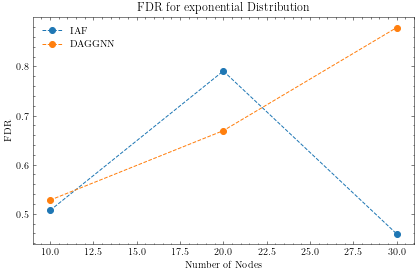

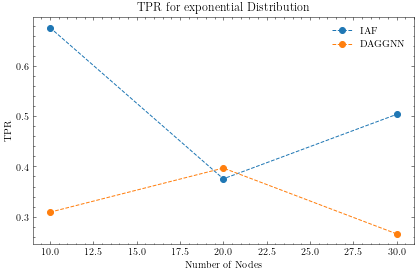

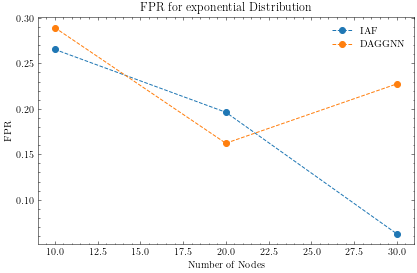

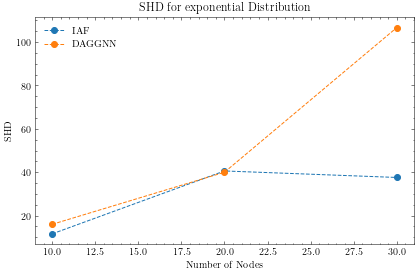

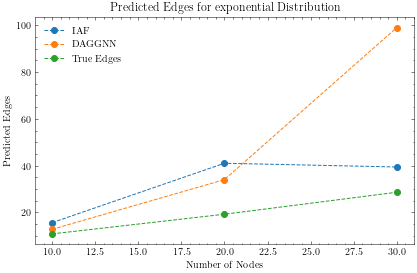

In [6]:
plot_indep(node_nums=[10,20,30], dist='exponential')

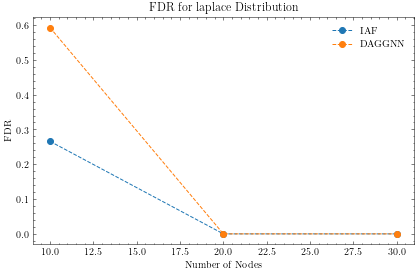

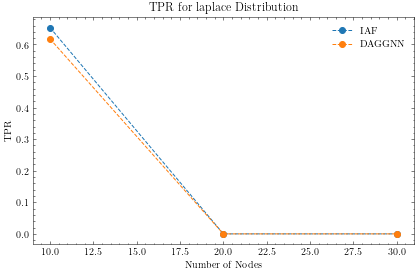

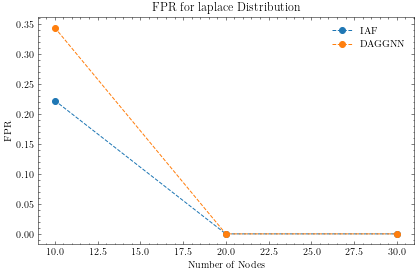

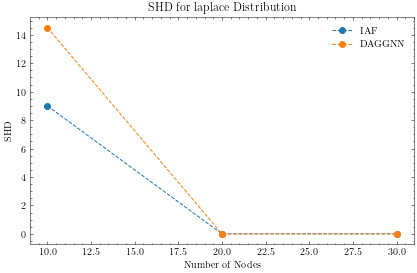

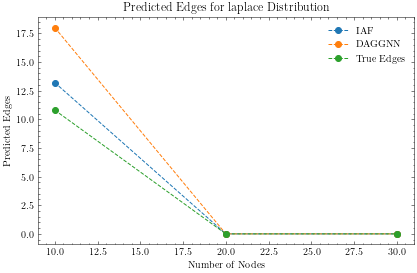

In [7]:
plot_indep(node_nums=[10,20,30], dist='laplace')

In [13]:
def plot_comparison_indep(node_size, seed, dist):
    folders = [f for f in os.listdir(f'results/independence/{dist}') if f[0].isdigit()]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    for idx, flow_type in enumerate(['IAF', 'DAGGNN']):
        folder = [f for f in folders if f'{flow_type}_node{node_size}_seed{seed}' in f][0]

        pred_G = np.loadtxt(f'results/independence/{dist}/{folder}/predG.txt', delimiter=' ').reshape(node_size, node_size)

        if flow_type == 'IAF' and 'best_ELBO_G.txt' in os.listdir(f'results/independence/{dist}/{folder}'):
            pred_G = np.loadtxt(f'results/independence/{dist}/{folder}/best_ELBO_G.txt', delimiter=' ').reshape(node_size, node_size)

        true_G = np.loadtxt(f'results/independence/{dist}/{folder}/trueG.txt', delimiter=' ').reshape(node_size, node_size)

        pred_G[np.abs(pred_G) < 0.3] = 0

        fdr, tpr, fpr, shd, nnz = count_accuracy(nx.DiGraph(true_G), nx.DiGraph(pred_G))

        if idx == 0:
            sns.heatmap(true_G, cmap=newcmp, ax=axes[0], vmin=-2, vmax=2, cbar=False)
            axes[0].set_title('True Graph', fontsize=20)
            for _, spine in axes[0].spines.items():
                spine.set_visible(True)
            axes[0].set_xticks([])
            axes[0].set_yticks([])
        sns.heatmap(pred_G, cmap=newcmp, ax=axes.ravel()[idx+1], vmin=-2, vmax=2, cbar_ax = cbar_ax if idx == 0 else None, cbar = (idx == 0))
        axes.ravel()[idx+1].set_title(flow_type + f' (SHD = {shd})', fontsize=20)
        for _, spine in axes.ravel()[idx+1].spines.items():
            spine.set_visible(True)
        axes.ravel()[idx+1].set_xticks([])
        axes.ravel()[idx+1].set_yticks([])
    fig.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig(f'Tex/fig/comparison_indep_{node_size}_{dist}_seed{seed}.pdf')

/var/folders/6r/ndnspf4n6n7_m8rb9bs7qdvr0000gp/T/ipykernel_24929/2634782683.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


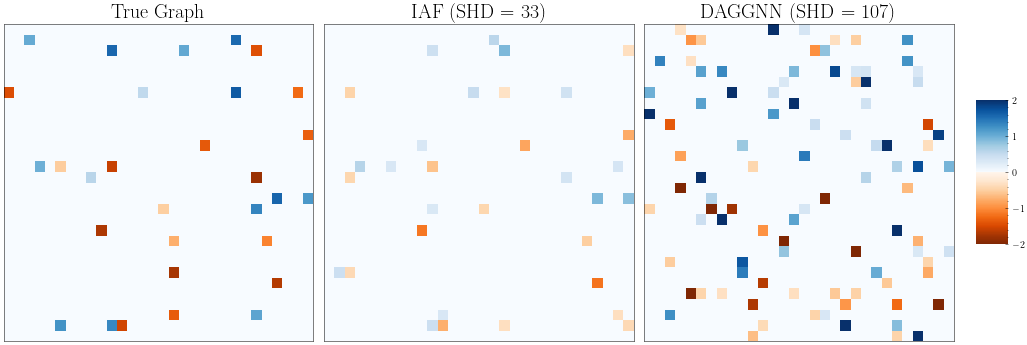

In [23]:
plot_comparison_indep(node_size=30, seed=301, dist='exponential')